
# Day 5 – Volatility & Risk  
## GARCH Volatility Modeling + VaR

**Goals**
- Understand volatility clustering & fat tails
- Fit a **GARCH(1,1)** model to daily oil returns
- Produce **volatility forecasts**
- Estimate **95% and 99% Value-at-Risk (VaR)**
- **Backtest** VaR (Kupiec & Christoffersen tests)

> Tip: If you don't have `arch` installed locally, run `pip install arch` in your environment before executing the fitting cells.


In [8]:

# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime

# Stats & diagnostics
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

# Try to import 'arch' for GARCH models
try:
    from arch import arch_model
    HAVE_ARCH = True
except Exception as e:
    HAVE_ARCH = False
    print("WARNING: The 'arch' package is not available. "
          "Install it with `pip install arch` to run GARCH modeling.\n", e)

# Plot settings (respecting no explicit color/style constraints)
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.grid'] = True

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

def summarize_series(x, name="series"):
    desc = x.describe(percentiles=[0.01, 0.05, 0.95, 0.99]).to_frame(name)
    desc.loc['skew'] = x.skew()
    desc.loc['kurtosis'] = x.kurtosis()
    return desc

def pct_to_decimal(p):
    """Convert e.g. 0.95 -> 95% text, and return p for convenience."""
    return p

def z_to_quantile(p):
    """Standard normal quantile for one-sided tail p (e.g., p=0.95 -> z for 95% VaR)."""
    from scipy.stats import norm
    return norm.ppf(1 - (1 - p))

def t_quantile(p, df):
    from scipy.stats import t
    return t.ppf(1 - (1 - p), df)

def kupiec_pof_test(violations, T, alpha):
    """Kupiec Proportion of Failures (POF) test.
    violations: number of VaR exceptions
    T: total number of forecasts
    alpha: VaR level (e.g., 0.95 or 0.99)
    Returns: LR_uc, p_value
    """
    from math import log
    from scipy.stats import chi2
    if T == 0:
        return np.nan, np.nan
    p_hat = violations / T if T > 0 else np.nan
    # Avoid log(0)
    if p_hat == 0 or p_hat == 1:
        p_hat = max(min(p_hat, 1 - 1e-12), 1e-12)
    if alpha == 1:
        alpha = 1 - 1e-12
    if alpha == 0:
        alpha = 1e-12
    LR_uc = -2 * ( (T - violations) * log(1 - alpha) + violations * log(alpha)
                   - ((T - violations) * log(1 - p_hat) + violations * log(p_hat)) )
    p_value = 1 - chi2.cdf(LR_uc, df=1)
    return LR_uc, p_value

def christoffersen_independence_test(hit_series):
    """Christoffersen independence test for VaR exceptions.
    hit_series: array-like of 0/1 where 1 indicates a VaR breach.
    Returns: LR_ind, p_value
    """
    from scipy.stats import chi2
    h = np.asarray(hit_series).astype(int)
    if len(h) < 2:
        return np.nan, np.nan
    # Transition counts
    n00 = np.sum((h[:-1] == 0) & (h[1:] == 0))
    n01 = np.sum((h[:-1] == 0) & (h[1:] == 1))
    n10 = np.sum((h[:-1] == 1) & (h[1:] == 0))
    n11 = np.sum((h[:-1] == 1) & (h[1:] == 1))
    n0 = n00 + n01
    n1 = n10 + n11
    # Transition probabilities
    pi01 = n01 / n0 if n0 > 0 else 0
    pi11 = n11 / n1 if n1 > 0 else 0
    pi = (n01 + n11) / (n0 + n1) if (n0 + n1) > 0 else 0
    # Likelihood ratio for independence
    def L(a,b,c): return ((1-a)**b) * (a**c) if 0 < a < 1 else 0
    # Avoid zero probs by adding tiny epsilon
    eps = 1e-12
    pi01 = min(max(pi01, eps), 1-eps)
    pi11 = min(max(pi11, eps), 1-eps)
    pi   = min(max(pi,   eps), 1-eps)
    LR_ind = -2 * ( np.log(L(pi, n0, n1)) - (np.log(L(pi01, n0, n01)) + np.log(L(pi11, n1, n11))) )
    p_value = 1 - chi2.cdf(LR_ind, df=1)
    return LR_ind, p_value

def christoffersen_conditional_coverage_test(hit_series, alpha):
    """Christoffersen conditional coverage combines Kupiec (frequency) + independence."""
    from scipy.stats import chi2
    h = np.asarray(hit_series).astype(int)
    T = len(h)
    v = int(h.sum())
    LR_uc, _ = kupiec_pof_test(v, T, 1 - alpha)  # note: alpha here as tail prob (e.g., 0.05)
    LR_ind, _ = christoffersen_independence_test(h)
    if np.isnan(LR_uc) or np.isnan(LR_ind):
        return np.nan, np.nan
    LR_cc = LR_uc + LR_ind
    p_value = 1 - chi2.cdf(LR_cc, df=2)
    return LR_cc, p_value



## 1) Load data & compute returns

- Provide a CSV with at least two columns: `Date` and `Price` (or `Close`).  
- This cell computes **log returns** suitable for GARCH.


In [9]:

# === Configure your input path here ===
# Example: data_path = Path('oil_prices.csv')
data_path = None  # set to your CSV path, e.g., Path('oil.csv')

def load_price_series(path=None):
    if path is None or not Path(path).exists():
        print("No CSV provided or path not found. Generating a synthetic price series for demonstration...")
        # Create a synthetic price path (random walk) for demo purposes
        n = 1500
        dates = pd.bdate_range(end=pd.Timestamp.today(), periods=n)
        # Simulate log-returns with volatility clustering using a simple GARCH(1,1) process if available
        if HAVE_ARCH:
            from arch.univariate import ConstantMean, GARCH, StudentsT
            y = np.zeros(n)
            omega, alpha, beta = 0.02, 0.08, 0.90
            eps = np.random.standard_t(df=6, size=n) * 0.01
            sigma2 = np.zeros(n)
            sigma2[0] = omega / (1 - alpha - beta)
            for t in range(1, n):
                sigma2[t] = omega + alpha * (y[t-1]**2) + beta * sigma2[t-1]
                y[t] = np.sqrt(sigma2[t]) * eps[t]
            prices = 60 * np.exp(np.cumsum(y))  # start around 60
            df = pd.DataFrame({'Date': dates, 'Price': prices})
        else:
            # Simpler fallback
            steps = np.random.normal(0, 0.01, size=n)
            prices = 60 * np.exp(np.cumsum(steps))
            df = pd.DataFrame({'Date': dates, 'Price': prices})
    else:
        df = pd.read_csv(path)
        # Try to auto-detect column names
        cols = {c.lower(): c for c in df.columns}
        date_col = cols.get('date', None)
        price_col = cols.get('price', cols.get('close', None))
        if date_col is None or price_col is None:
            raise ValueError("CSV must have columns named 'Date' and 'Price' (or 'Close').")
        df = df[[date_col, price_col]].rename(columns={date_col: 'Date', price_col: 'Price'})
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date')
    df = df.dropna().reset_index(drop=True)
    df['Return'] = np.log(df['Price']).diff()
    df = df.dropna().reset_index(drop=True)
    return df

df = load_price_series(data_path)

print(df.head())
print("\nRows:", len(df))


No CSV provided or path not found. Generating a synthetic price series for demonstration...
        Date      Price    Return
0 2019-12-06  59.385724 -0.010291
1 2019-12-09  60.126676  0.012400
2 2019-12-10  59.739297 -0.006464
3 2019-12-11  60.014283  0.004593
4 2019-12-12  60.764182  0.012418

Rows: 1499



## 2) Quick EDA & diagnostics

- Visualize prices & returns
- Check stationarity
- Test for ARCH effects (volatility clustering)


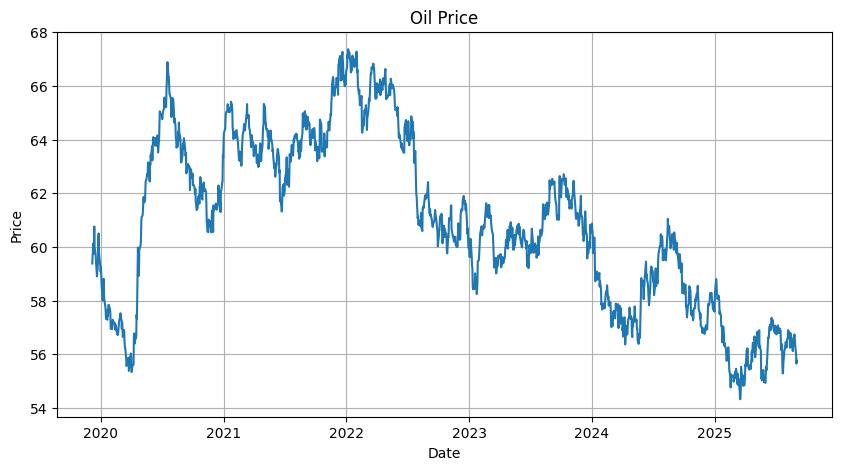

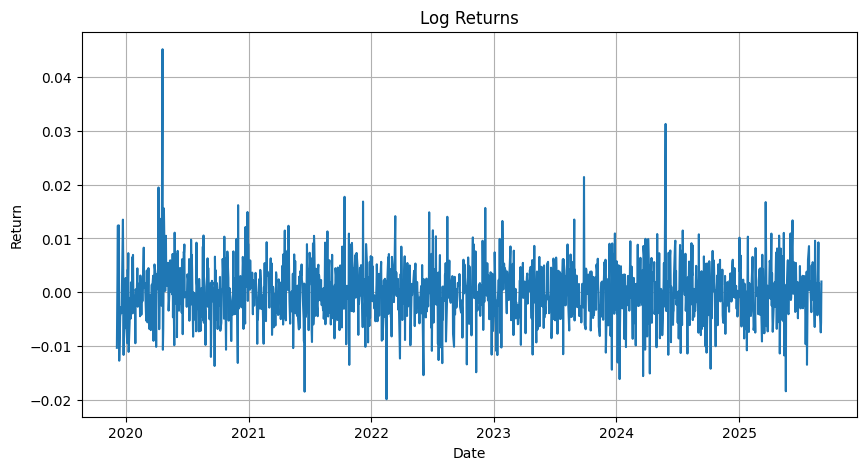

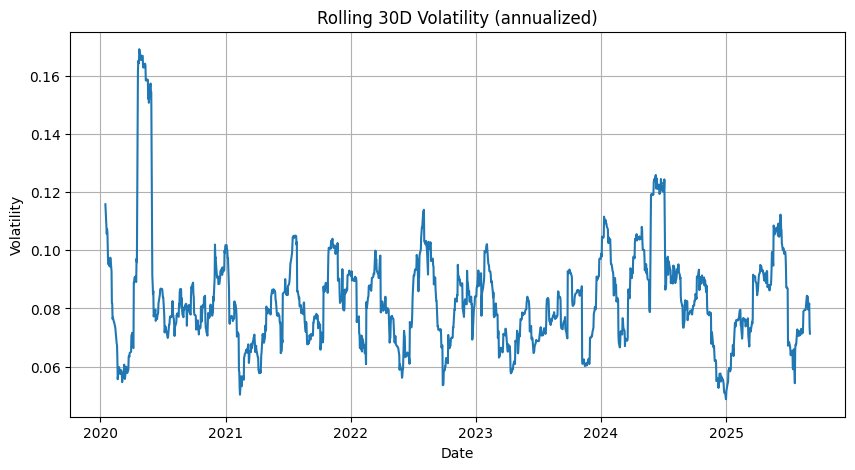

              returns
count     1499.000000
mean        -0.000049
std          0.005363
min         -0.019829
1%          -0.013101
5%          -0.008802
50%         -0.000013
95%          0.008640
99%          0.013517
max          0.045120
skew         0.532114
kurtosis     4.470786
ADF stat: -41.096, p-value: 0
Critical values: {'1%': np.float64(-3.4347228578139943), '5%': np.float64(-2.863471337969528), '10%': np.float64(-2.5677982210726897)}

Ljung-Box on returns:
       lb_stat  lb_pvalue
10   7.123855   0.713703
20  13.809927   0.840001

Ljung-Box on squared returns:
       lb_stat  lb_pvalue
10  24.292862   0.006860
20  26.803103   0.140895

ARCH LM test: LM-stat=22.276, p=0.0138 | F-stat=2.245, p=0.0135


In [10]:

# Plot Price and Returns
fig, ax = plt.subplots()
ax.plot(df['Date'], df['Price'])
ax.set_title('Oil Price')
ax.set_xlabel('Date'); ax.set_ylabel('Price')
plt.show()

fig, ax = plt.subplots()
ax.plot(df['Date'], df['Return'])
ax.set_title('Log Returns')
ax.set_xlabel('Date'); ax.set_ylabel('Return')
plt.show()

# Rolling volatility (annualized from daily ~252 trading days)
rolling_vol = df['Return'].rolling(30).std() * np.sqrt(252)

fig, ax = plt.subplots()
ax.plot(df['Date'], rolling_vol)
ax.set_title('Rolling 30D Volatility (annualized)')
ax.set_xlabel('Date'); ax.set_ylabel('Volatility')
plt.show()

# Summary stats
summary = summarize_series(df['Return'], 'returns')
print(summary)

# ADF test (stationarity)
adf_stat, adf_p, _, _, crit, _ = adfuller(df['Return'].dropna())
print(f"ADF stat: {adf_stat:.3f}, p-value: {adf_p:.3g}")
print('Critical values:', crit)

# Ljung-Box on returns & squared returns (autocorr & volatility clustering)
lb_ret = acorr_ljungbox(df['Return'], lags=[10, 20], return_df=True)
lb_sq  = acorr_ljungbox(df['Return']**2, lags=[10, 20], return_df=True)
print("\nLjung-Box on returns:\n", lb_ret)
print("\nLjung-Box on squared returns:\n", lb_sq)

# Engle's ARCH LM test
lm_stat, lm_p, f_stat, f_p = het_arch(df['Return'])
print(f"\nARCH LM test: LM-stat={lm_stat:.3f}, p={lm_p:.3g} | F-stat={f_stat:.3f}, p={f_p:.3g}")



## 3) Fit GARCH(1,1)

- Mean model: constant (you can change to ARX if needed)
- Volatility model: GARCH(1,1)
- Distribution: Student's t (handles fat tails better than Normal)


In [11]:

if not HAVE_ARCH:
    raise RuntimeError("'arch' is required for this section. Install it with `pip install arch`." )

# Fit GARCH(1,1) with Student's t
am = arch_model(df['Return']*100, mean='Constant', vol='GARCH', p=1, q=1, dist='t')  # scale to percent
res = am.fit(update_freq=10, disp='off')
print(res.summary())

# Extract conditional volatility (in % terms because we scaled returns by 100)
df['sigma_%'] = res.conditional_volatility
df['sigma'] = df['sigma_%'] / 100.0  # back to decimal

# Persistence
params = res.params
alpha = params.get('alpha[1]', np.nan)
beta  = params.get('beta[1]', np.nan)
omega = params.get('omega', np.nan)
print(f"\nPersistence (alpha + beta): {alpha + beta:.4f}")


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1138.18
Distribution:      Standardized Student's t   AIC:                           2286.36
Method:                  Maximum Likelihood   BIC:                           2312.92
                                              No. Observations:                 1499
Date:                      Wed, Sep 03 2025   Df Residuals:                     1498
Time:                              17:39:23   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------


## 4) Volatility forecast

- 1-step-ahead and multi-step forecasts
- Plot the recent in-sample volatility and out-of-sample forecast


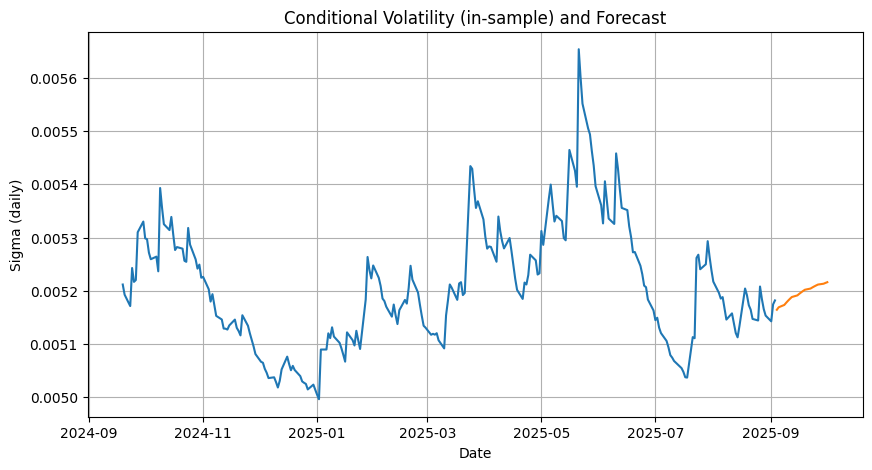

In [12]:

h = 20  # forecast horizon (days)

forecasts = res.forecast(horizon=h, reindex=False)
# 'variance' is in squared percent units
f_var_pct2 = forecasts.variance.iloc[-1]  # last forecast row
f_sigma = np.sqrt(f_var_pct2) / 100.0     # convert from %^2 to decimal sigma

# Plot recent sigma and forecast
last_n = 250
fig, ax = plt.subplots()
ax.plot(df['Date'].iloc[-last_n:], df['sigma'].iloc[-last_n:])
ax.plot(pd.date_range(df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=h, freq='B'), f_sigma.values)
ax.set_title('Conditional Volatility (in-sample) and Forecast')
ax.set_xlabel('Date'); ax.set_ylabel('Sigma (daily)')
plt.show()



## 5) VaR estimation (95% & 99%)

We compute three flavors:
1. **Parametric (GARCH + distribution):** Uses the model-implied mean & sigma and the chosen distribution's quantile.  
2. **Historical VaR:** Rolling empirical quantiles of past returns.  
3. **Filtered Historical Simulation (FHS):** Standardize residuals by model sigma, resample them, then re-scale by forecast sigma.


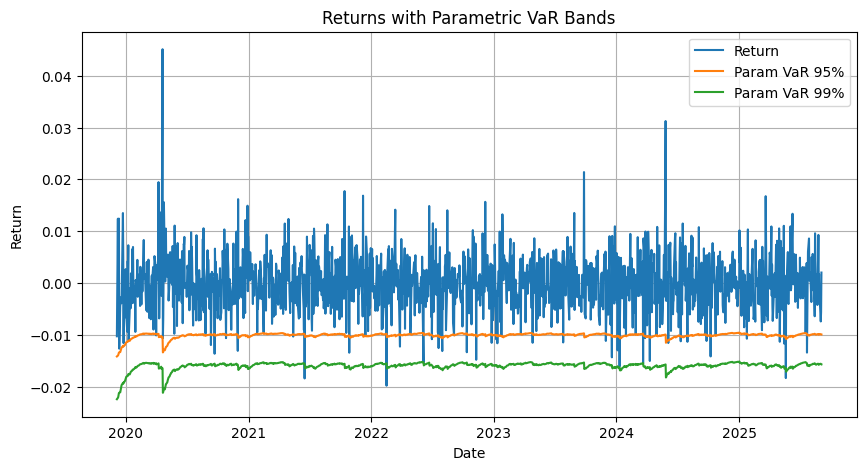

Exceptions @ 95%: 43 out of 1499
Exceptions @ 99%: 5 out of 1499


In [13]:

from scipy.stats import t, norm

alpha_levels = [0.95, 0.99]  # confidence levels for VaR

# In-sample conditional mean from the fitted model
mu_hat = res.params.get('mu', 0.0) / 100.0  # model mean in decimal (since we scaled by 100)
# Fitted residuals & sigma
resid = (df['Return'] - mu_hat) / df['sigma']
resid = resid.replace([np.inf, -np.inf], np.nan).dropna()

# Degrees of freedom for t-dist (if applicable)
nu = res.params.get('nu', None)

def parametric_var(sigma, alpha, dist='t', nu=None, mu=0.0):
    if dist == 't' and nu is not None:
        q = t.ppf(1 - alpha, df=nu)
    else:
        q = norm.ppf(1 - alpha)
    return mu + sigma * q  # lower tail VaR (returns are negative on bad days)

# Historical VaR (rolling window)
# Historical VaR (rolling window)
window = 250
hist_var = pd.DataFrame(index=df.index)

for a in alpha_levels:
    quantile_level = 1 - a
    hist_var[f'HistVaR_{int(a*100)}'] = df['Return'].rolling(window).quantile(quantile_level)
    
# Compute 1-step-ahead VaR series using in-sample sigma_t
var_df = pd.DataFrame(index=df.index, columns=[f'ParamVaR_{int(a*100)}' for a in alpha_levels])

for a in alpha_levels:
    if nu is not None:
        var_df[f'ParamVaR_{int(a*100)}'] = mu_hat + df['sigma'] * t.ppf(1 - a, df=nu)
    else:
        var_df[f'ParamVaR_{int(a*100)}'] = mu_hat + df['sigma'] * norm.ppf(1 - a)

# Plot returns with Parametric VaR bands
fig, ax = plt.subplots()
ax.plot(df['Date'], df['Return'], label='Return')
for a in alpha_levels:
    ax.plot(df['Date'], var_df[f'ParamVaR_{int(a*100)}'], label=f'Param VaR {int(a*100)}%')
ax.set_title('Returns with Parametric VaR Bands')
ax.set_xlabel('Date'); ax.set_ylabel('Return')
ax.legend()
plt.show()

# Identify breaches for 95% and 99%
breaches = {}
for a in alpha_levels:
    col = f'ParamVaR_{int(a*100)}'
    breaches[col] = (df['Return'] < var_df[col]).astype(int)

# Show simple breach counts
for a in alpha_levels:
    col = f'ParamVaR_{int(a*100)}'
    print(f"Exceptions @ {int(a*100)}%: {breaches[col].sum()} out of {len(df)}")    



## 6) VaR backtesting

We run:
- **Kupiec POF test** (correct frequency of breaches)
- **Christoffersen independence** (no clustering of breaches)
- **Christoffersen conditional coverage** (both together)


In [14]:

for a in alpha_levels:
    col = f'ParamVaR_{int(a*100)}'
    hits = breaches[col].values
    v = hits.sum()
    T = len(hits)
    LR_uc, p_uc = kupiec_pof_test(v, T, a)  # here `a` is the confidence (e.g., 0.95)
    LR_ind, p_ind = christoffersen_independence_test(hits)
    LR_cc, p_cc = christoffersen_conditional_coverage_test(hits, 1 - a)  # pass tail prob (e.g., 0.05)
    print(f"\n=== Backtest @ {int(a*100)}% ===")
    print(f"Kupiec POF:    LR={LR_uc:.3f}, p={p_uc:.4f}")
    print(f"Independence:  LR={LR_ind:.3f}, p={p_ind:.4f}")
    print(f"Cond. Coverage LR={LR_cc:.3f}, p={p_cc:.4f}")



=== Backtest @ 95% ===
Kupiec POF:    LR=8337.813, p=0.0000
Independence:  LR=-0.038, p=1.0000
Cond. Coverage LR=8337.775, p=0.0000

=== Backtest @ 99% ===
Kupiec POF:    LR=13693.335, p=0.0000
Independence:  LR=-0.000, p=1.0000
Cond. Coverage LR=13693.335, p=0.0000



## 7) Out-of-sample VaR forecast example

This computes **h-step ahead** VaR using model forecasts. Adjust `h` and the confidence levels as needed.


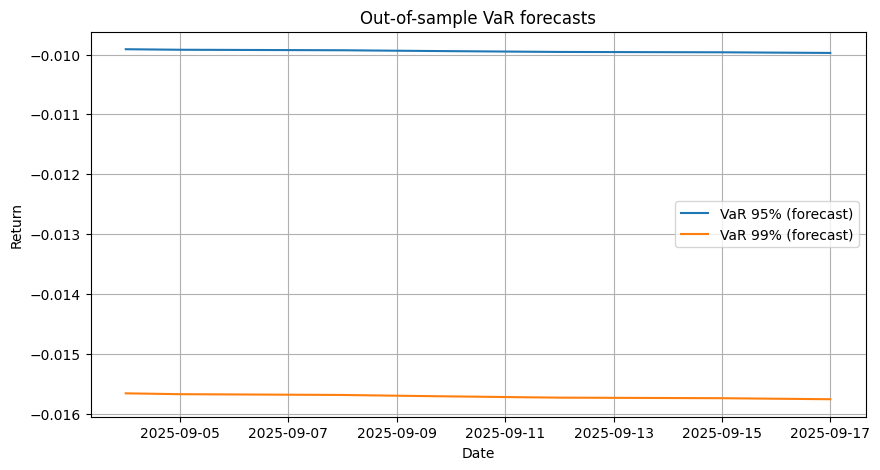

In [15]:

h = 10
fc = res.forecast(horizon=h, reindex=False)
f_mu = res.params.get('mu', 0.0) / 100.0
f_sigma = np.sqrt(fc.variance.iloc[-1]) / 100.0  # decimal

fvar = {}
for a in alpha_levels:
    if nu is not None:
        fvar[a] = f_mu + f_sigma * t.ppf(1 - a, df=nu)
    else:
        fvar[a] = f_mu + f_sigma * norm.ppf(1 - a)

# Plot the out-of-sample VaR
future_dates = pd.date_range(df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=h, freq='B')
fig, ax = plt.subplots()
for a in alpha_levels:
    ax.plot(future_dates, fvar[a].values, label=f'VaR {int(a*100)}% (forecast)')
ax.set_title('Out-of-sample VaR forecasts')
ax.set_xlabel('Date'); ax.set_ylabel('Return')
ax.legend()
plt.show()



## 8) Interpretation guide & notes

- **Volatility clustering**: You should see periods where high volatility follows high volatility, and low follows low.  
- **Fat tails**: If kurtosis >> 3 (normal), your return distribution has heavy tails; Student's t is usually a better fit.  
- **Persistence**: `alpha + beta` close to 1 indicates highly persistent volatility.  
- **Distribution choice**: Try `dist='normal'`, `dist='t'`, or `dist='skewt'` and compare likelihood/AIC and VaR performance.  
- **Mean model**: You can switch to AR terms (e.g., `mean='ARX'`) if there is return autocorrelation.  
- **Backtests**: Ideally, the Kupiec/Christoffersen p-values are not tiny; very small p-values suggest the VaR is mis-calibrated.  
- **Practical caution**: VaR is not coherent (fails subadditivity); consider **Expected Shortfall (ES/CVaR)** as well.  
- **Data quality**: Be careful with missing days, roll adjustments (for futures), and corporate actions (if using ETFs).  



## 9) (Optional) Expected Shortfall (ES)

Expected Shortfall (a.k.a. CVaR) is the **average loss given that loss exceeds VaR**. It's often preferred to VaR.


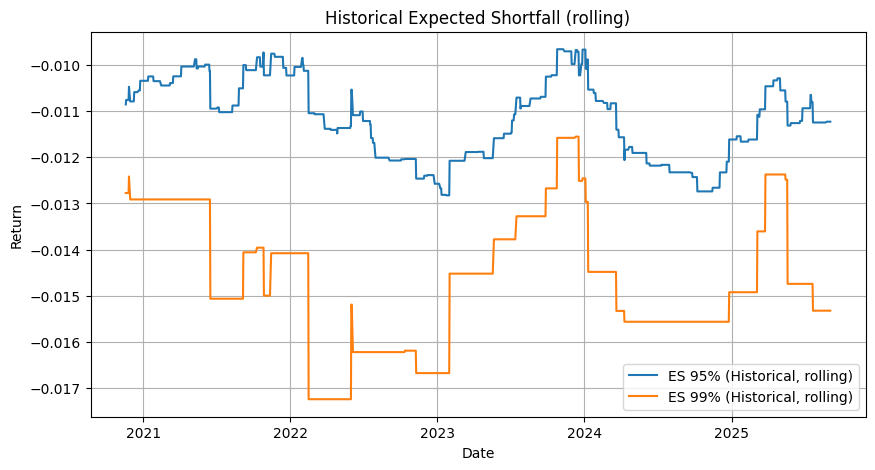

In [16]:

def expected_shortfall_from_residuals(returns, var_series):
    # Simple historical ES estimate conditional on returns < VaR
    es_vals = []
    for r, v in zip(returns, var_series):
        es_vals.append(np.nan)  # placeholder for alignment
    # Rolling ES with a window
    window = 250
    es_95 = returns.rolling(window).apply(lambda x: x[x < np.quantile(x, 0.05)].mean() if np.any(x < np.quantile(x, 0.05)) else np.nan, raw=False)
    es_99 = returns.rolling(window).apply(lambda x: x[x < np.quantile(x, 0.01)].mean() if np.any(x < np.quantile(x, 0.01)) else np.nan, raw=False)
    return es_95, es_99

es95, es99 = expected_shortfall_from_residuals(df['Return'], var_df['ParamVaR_95'])
fig, ax = plt.subplots()
ax.plot(df['Date'], es95, label='ES 95% (Historical, rolling)')
ax.plot(df['Date'], es99, label='ES 99% (Historical, rolling)')
ax.set_title('Historical Expected Shortfall (rolling)')
ax.set_xlabel('Date'); ax.set_ylabel('Return')
ax.legend()
plt.show()



## 10) Export key outputs

Save the fitted volatility and VaR series to CSV for your report.


In [17]:

out = pd.concat([df[['Date','Price','Return','sigma']], var_df], axis=1)
out_path = Path('garch_var_outputs.csv')
out.to_csv(out_path, index=False)
print('Saved:', out_path.resolve())


Saved: C:\Users\Samneh\Desktop\QuantDay1-14\garch_var_outputs.csv
